Необходимо создать, обучить нейронную сеть с точностью не менее 85% и упаковать её в архив для загрузки на демо-панель:
* создать нейронную сеть для распознавания марки автомобиля из 3х вариантов
* сохраните веса
* подготовить запуск модели "из коробки"
* подготовить архив с готовой нейронной сетью для загрузки в демо-панель


In [1]:
#Модули
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Задание гиперпараметров
TRAIN_PATH = '/content/cars'
TEST_PATH = '/content/cars_test'

TEST_SPLIT = 0.1
VAL_SPLIT = 0.2

IMG_WIDTH = 128
IMG_HEIGHT = 64
IMG_CHANNELS = 3

#Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 60                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0003)          # Оптимизатор

In [3]:
#Загрузка датасета
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [4]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "middle_fmr.zip" -d {TRAIN_PATH}

In [5]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


In [6]:
photo_1 = '/content/cars/Ferrari/car_Ferrari__0.png'
photo_1 = '/content/cars_test/Ferrari/car_Ferrari__0.png'

In [7]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [8]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [9]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [10]:
len(train_generator[0]) == 24

False

In [11]:
train_generator[0]
# (список пар изображений-меток)

(array([[[[0.19607845, 0.21176472, 0.24705884],
          [0.19215688, 0.20784315, 0.24313727],
          [0.19215688, 0.20392159, 0.2392157 ],
          ...,
          [0.62352943, 0.62352943, 0.6431373 ],
          [0.62352943, 0.62352943, 0.6431373 ],
          [0.62352943, 0.62352943, 0.6431373 ]],
 
         [[0.21960786, 0.23529413, 0.27058825],
          [0.21960786, 0.23137257, 0.27058825],
          [0.21960786, 0.23137257, 0.27058825],
          ...,
          [0.48235297, 0.4784314 , 0.49803925],
          [0.49803925, 0.49803925, 0.50980395],
          [0.5058824 , 0.50980395, 0.5254902 ]],
 
         [[0.227451  , 0.25490198, 0.2901961 ],
          [0.227451  , 0.25490198, 0.2901961 ],
          [0.227451  , 0.2509804 , 0.2901961 ],
          ...,
          [0.5529412 , 0.5568628 , 0.57254905],
          [0.5411765 , 0.54509807, 0.56078434],
          [0.5254902 , 0.53333336, 0.54509807]],
 
         ...,
 
         [[0.28627452, 0.23137257, 0.13333334],
          [0.28627

In [12]:
train_generator[0][0][0]
# изображение

array([[[0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.8705883 , 0.8745099 , 0.8980393 ],
        [0.8705883 , 0.8745099 , 0.8980393 ],
        [0.8705883 , 0.8745099 , 0.8980393 ]],

       [[0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.8745099 , 0.87843144, 0.90196085],
        [0.8745099 , 0.87843144, 0.90196085],
        [0.8745099 , 0.87843144, 0.90196085]],

       [[0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.8745099 , 0.87843144, 0.90196085],
        [0.8745099 , 0.87843144, 0.90196085],
        [0.8745099 , 0.87843144, 0.90196085]],

       ...,

       [[0.48235297, 0.41960788, 0.38431376],
        [0.48235297, 0.42352945, 0.38431376],
        [0.48235297, 0

In [13]:
train_generator[0][0][1]
# метка

array([[[0.89019614, 0.8941177 , 0.86274517],
        [0.91372555, 0.91372555, 0.87843144],
        [0.909804  , 0.9058824 , 0.87843144],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.8588236 , 0.8745099 , 0.8431373 ],
        [0.8862746 , 0.89019614, 0.86274517],
        [0.8862746 , 0.8862746 , 0.8588236 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.90196085, 0.91372555, 0.8862746 ],
        [0.91372555, 0.9215687 , 0.8941177 ],
        [0.89019614, 0.90196085, 0.8745099 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.5411765 , 0.5803922 , 0.64705884],
        [0.6156863 , 0.65882355, 0.72156864],
        [0.58431375, 0

In [14]:
class Some:
  def __init__(self, array):
    self.array = array
  def run(self):
    return '123'

  def __len__(self):
    return len(self.array)


In [15]:
sss = Some([1,2,3,4,5])

In [16]:
sss.run()

'123'

In [17]:
len(sss.array)

5

In [18]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (24, 64, 128, 3), (24, 3), батчей: 103
Формы данных   проверочной выборки: (24, 64, 128, 3), (24, 3), батчей: 26
Формы данных      тестовой выборки: (341, 64, 128, 3), (341, 3), батчей: 1

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов      тестовой выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


In [19]:
x_train, y_train = train_generator[0]

In [20]:
len(x_train), len(y_train)

(24, 24)

In [21]:
y_train[0].shape

(3,)

In [22]:
x_train[0].shape

(64, 128, 3)

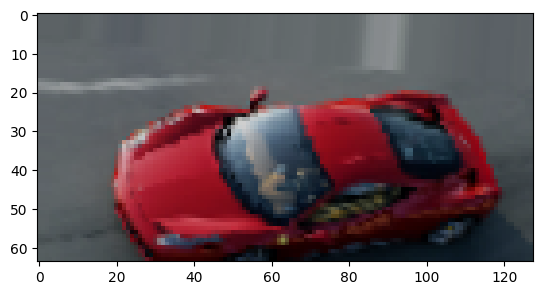

In [23]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [23]:
x_train, y_train = train_generator[0]

In [24]:
batch = train_generator[0]

In [25]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

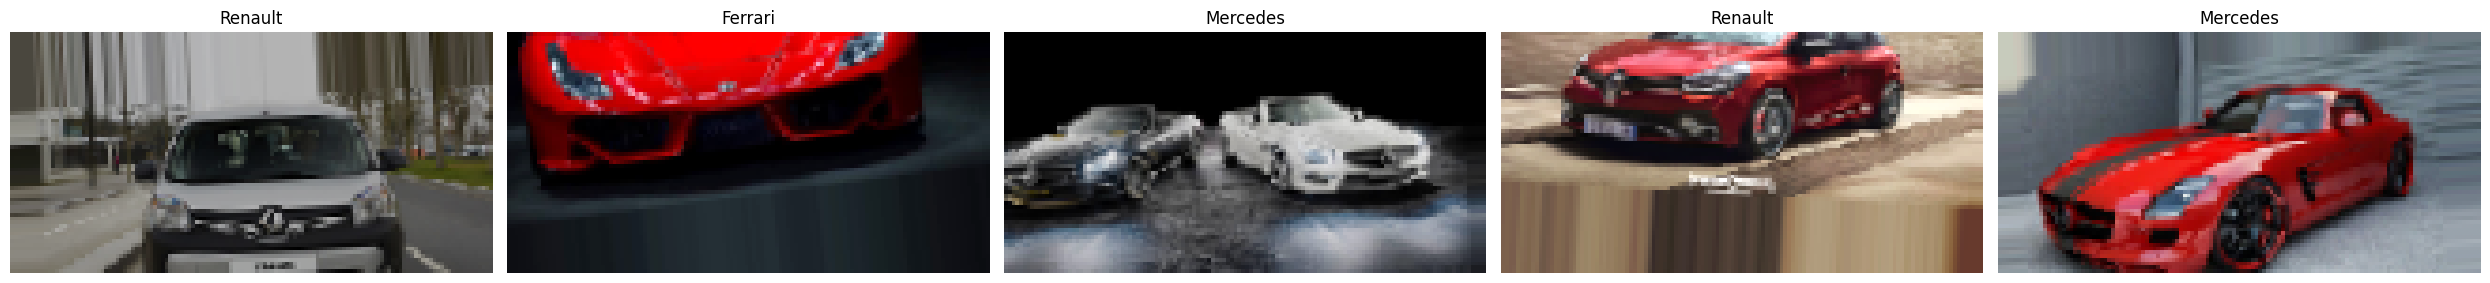

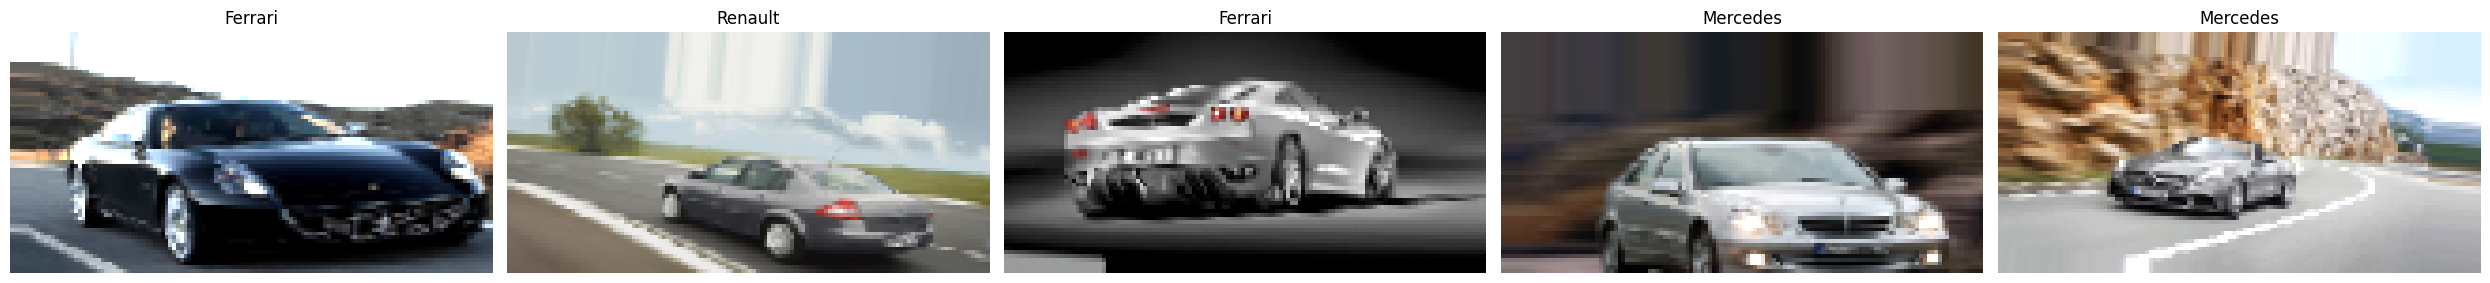

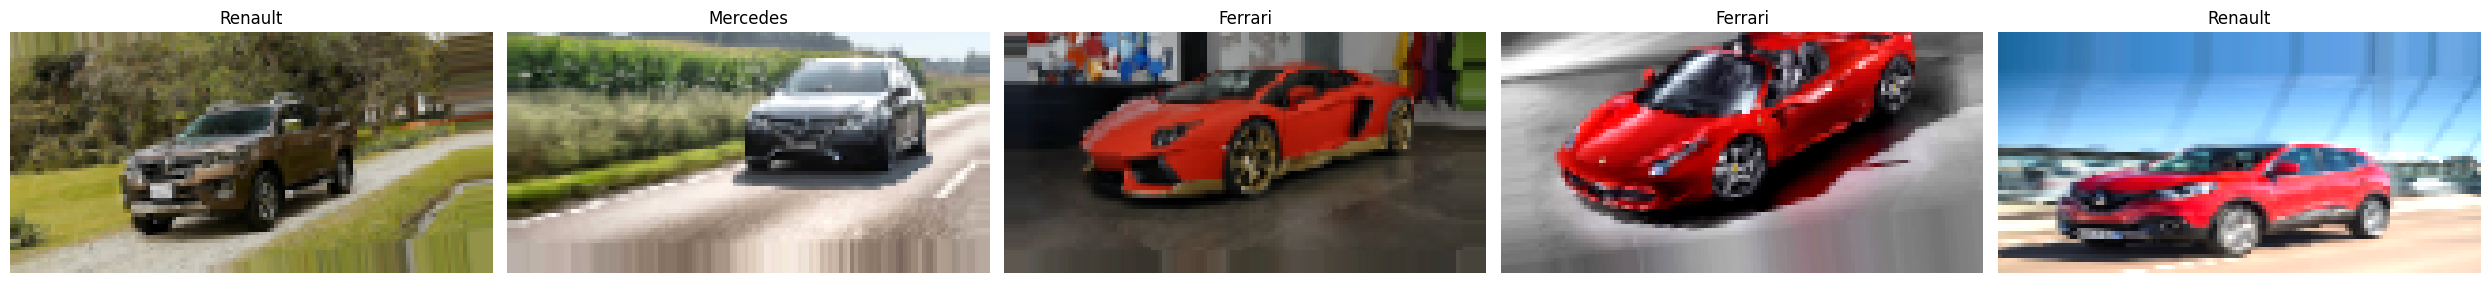

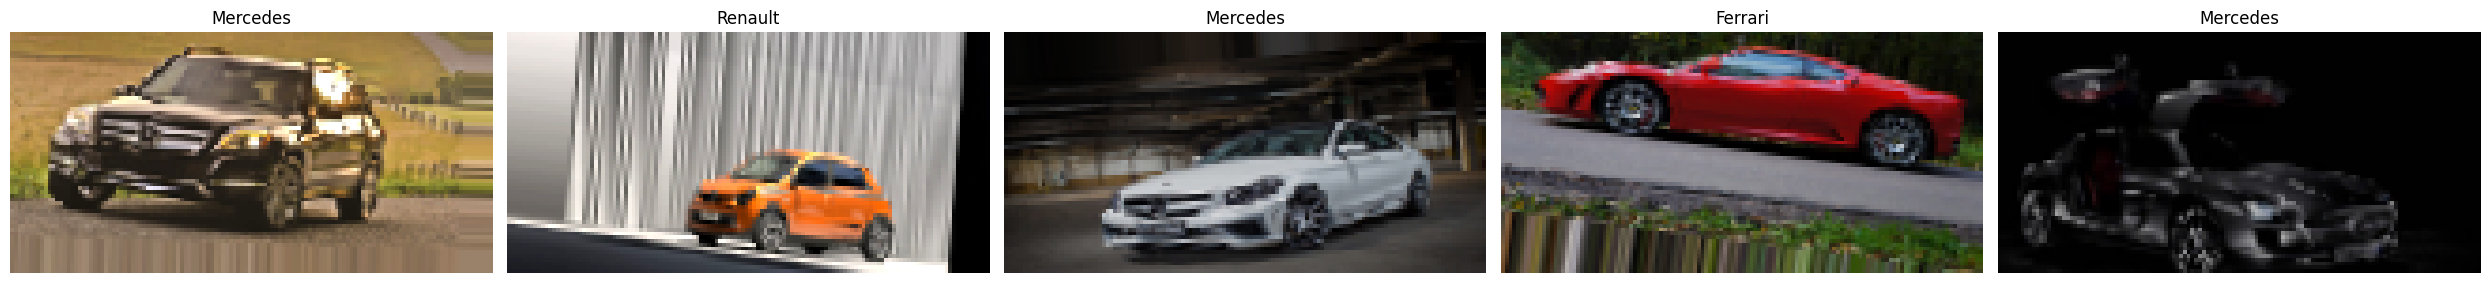

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

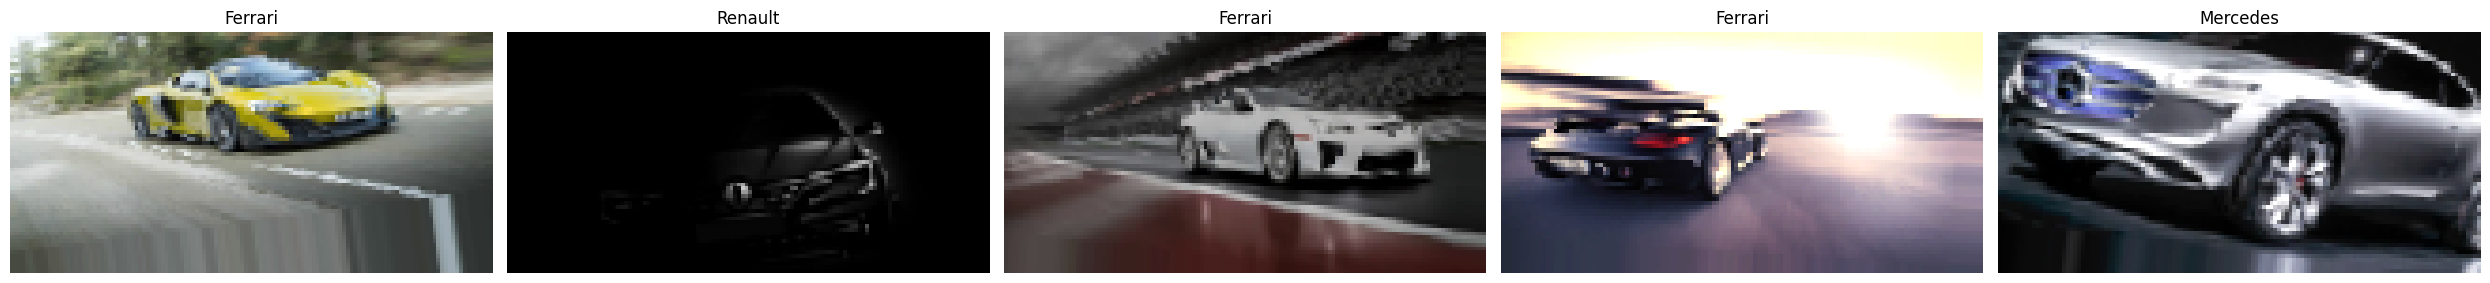

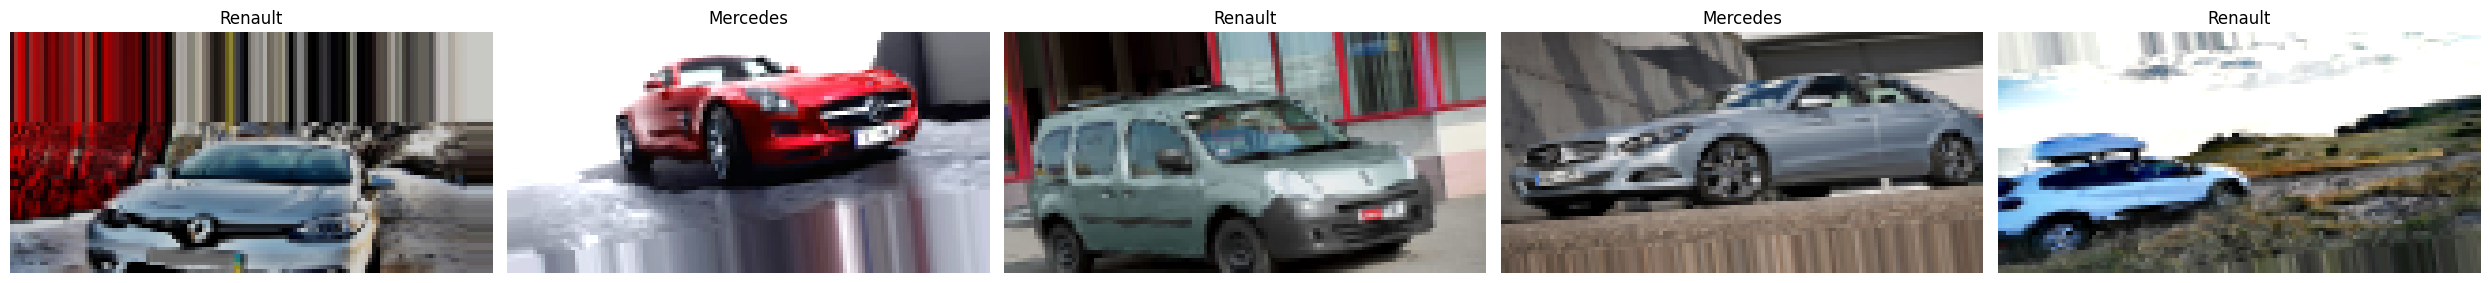

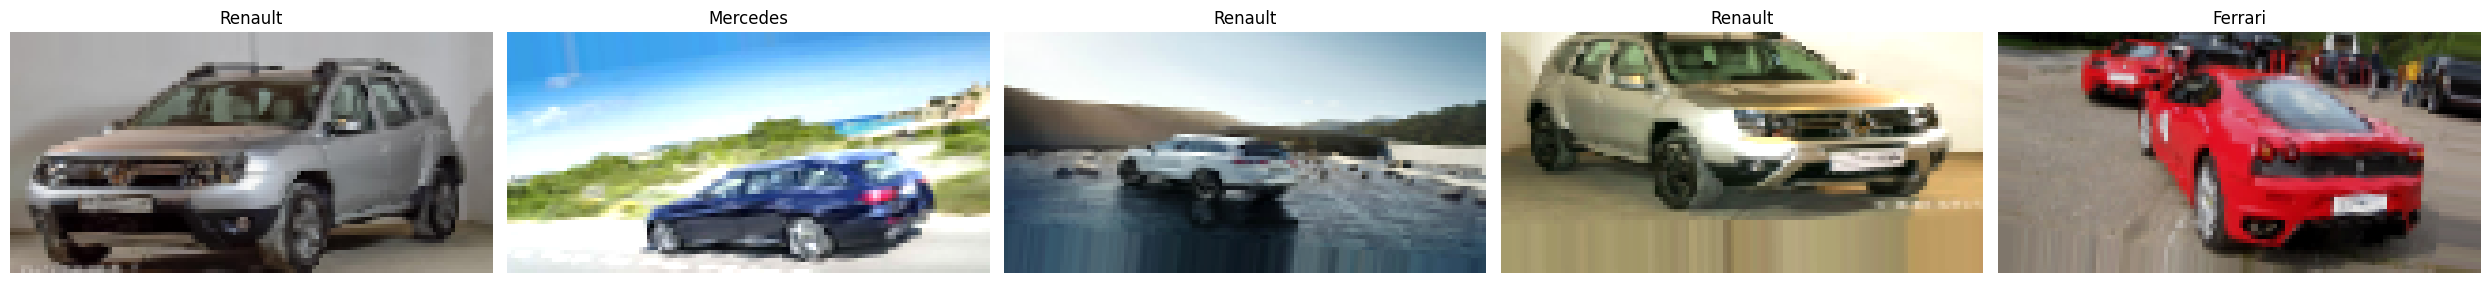

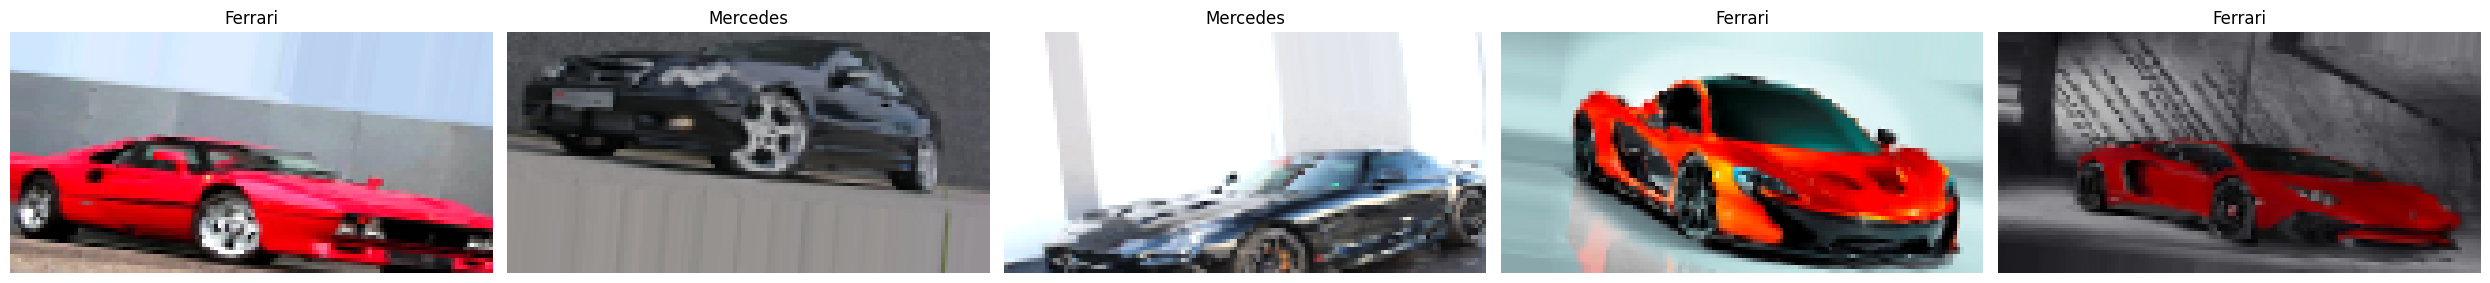

In [ ]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

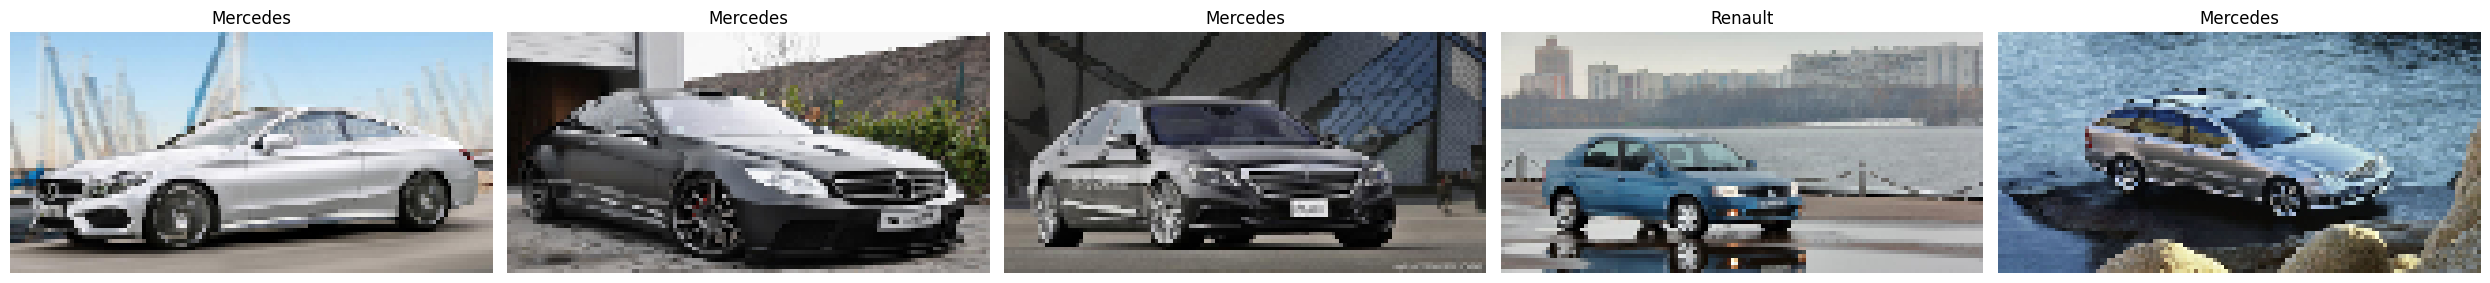

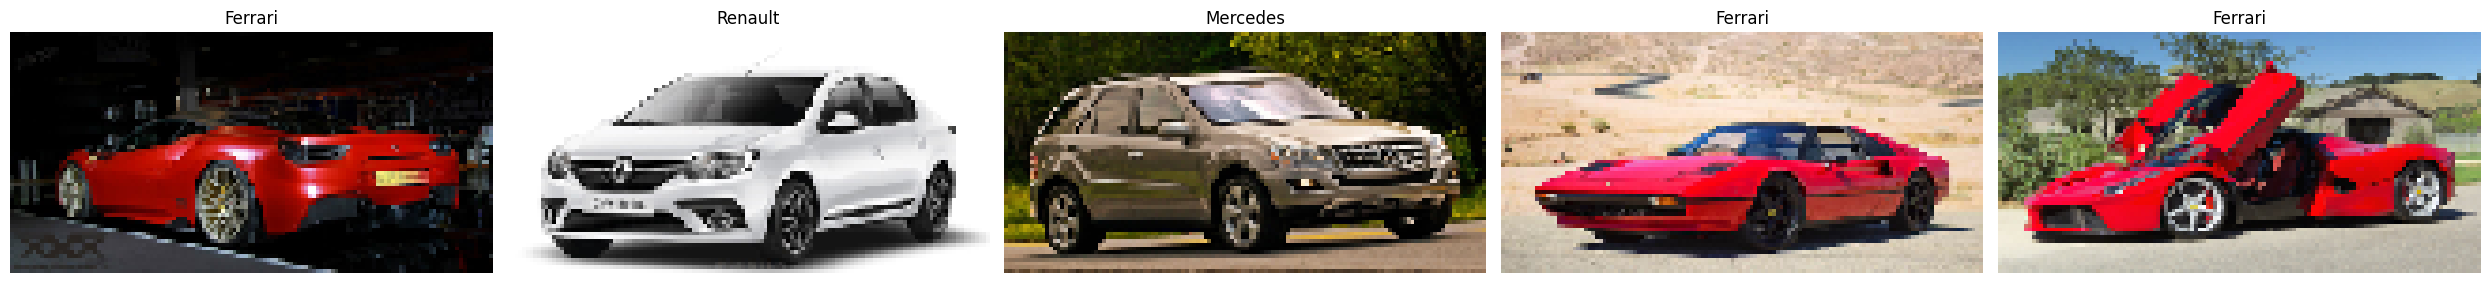

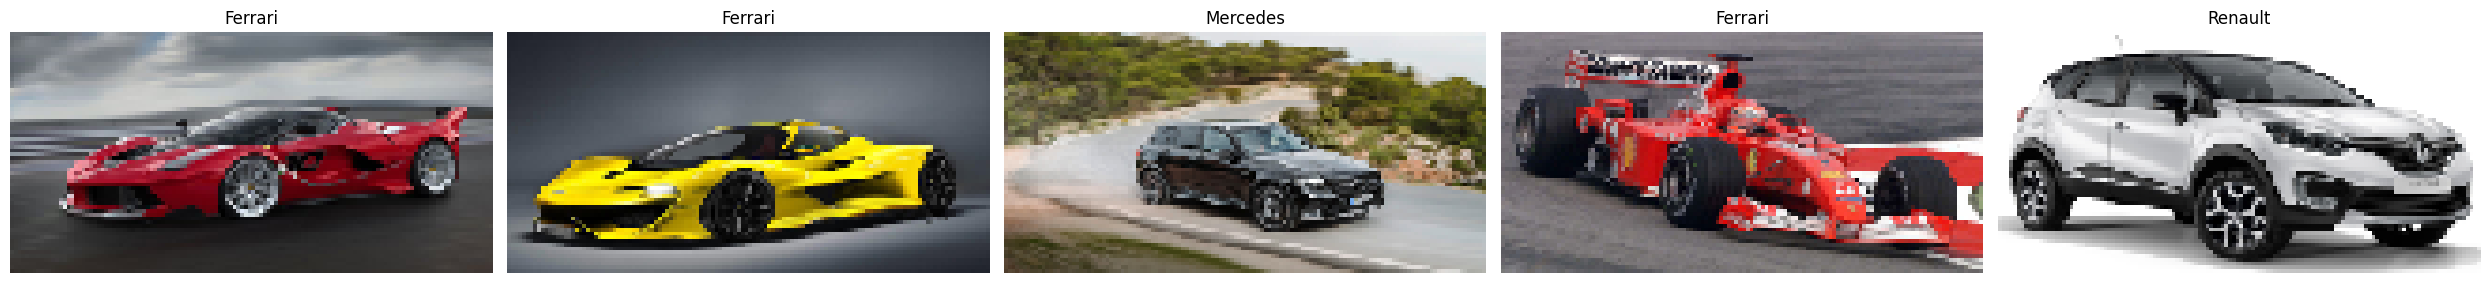

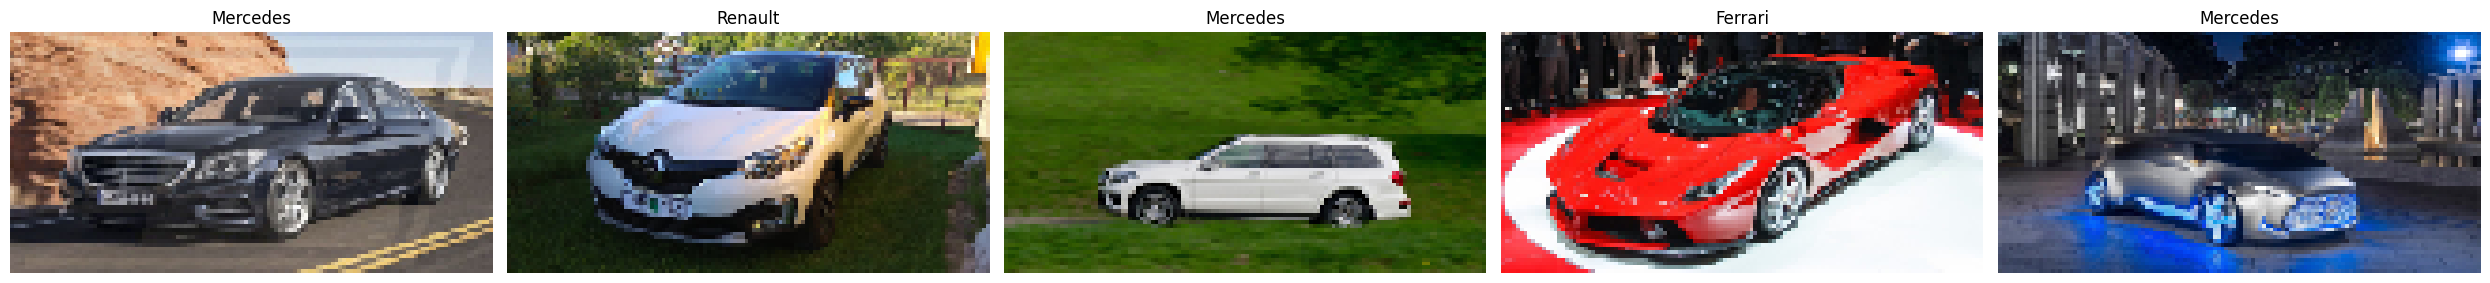

In [ ]:
# Вывод примеров из 0-го (единственного) батча test_generator
show_batch(test_generator[0])

In [26]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [27]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [28]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 128, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 16, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 16, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,947,523 (37.95 MB)

 Trainable params: 9,944,579 (37.94 MB)

 Non-trainable params: 2,944 (11.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 39s 240ms/step - accuracy: 0.4403 - loss: 1.5589 - val_accuracy: 0.3387 - val_loss: 7.7841
Epoch 2/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.5261 - loss: 1.1693 - val_accuracy: 0.3387 - val_loss: 2.4114
Epoch 3/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.5240 - loss: 1.1139 - val_accuracy: 0.3679 - val_loss: 2.6490
Epoch 4/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.5547 - loss: 1.1079 - val_accuracy: 0.3825 - val_loss: 1.5221
Epoch 5/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.5690 - loss: 1.0393 - val_accuracy: 0.4263 - val_loss: 1.4008
Epoch 6/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.5699 - loss: 1.0100 - val_accuracy: 0.4360 - val_loss: 1.8696
Epoch 7/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.5528 - loss: 1.0396 - val_accuracy: 0.5413 - val_loss: 1.3345
Epoch 8/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.5971 - loss: 0

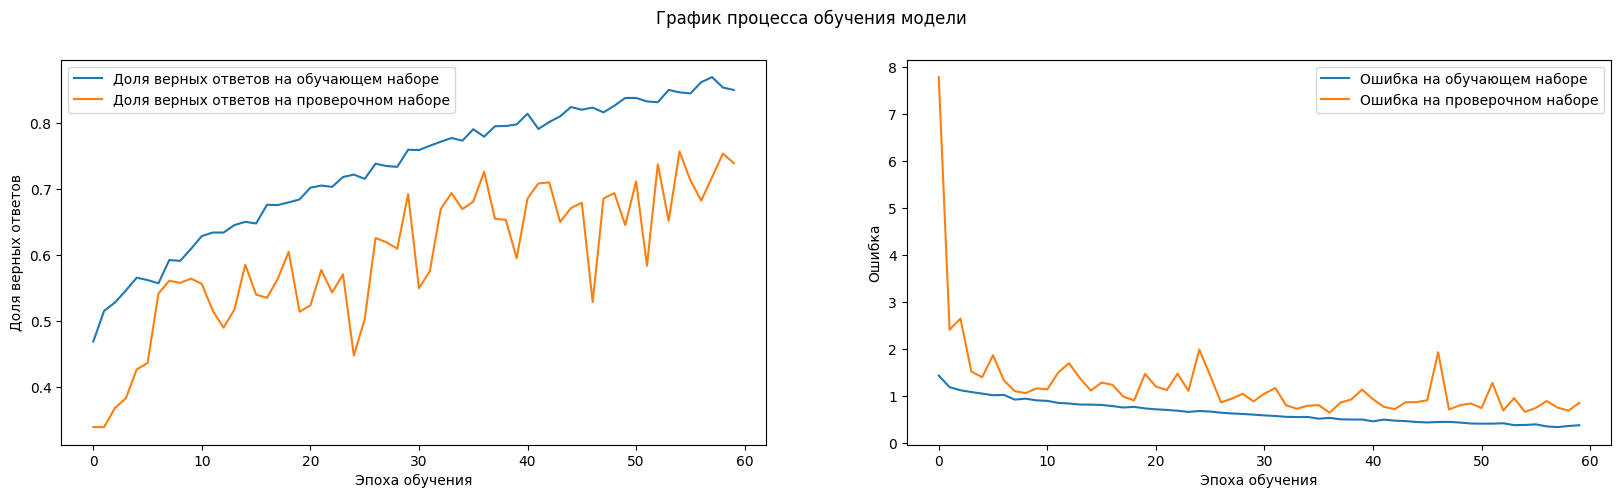

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step


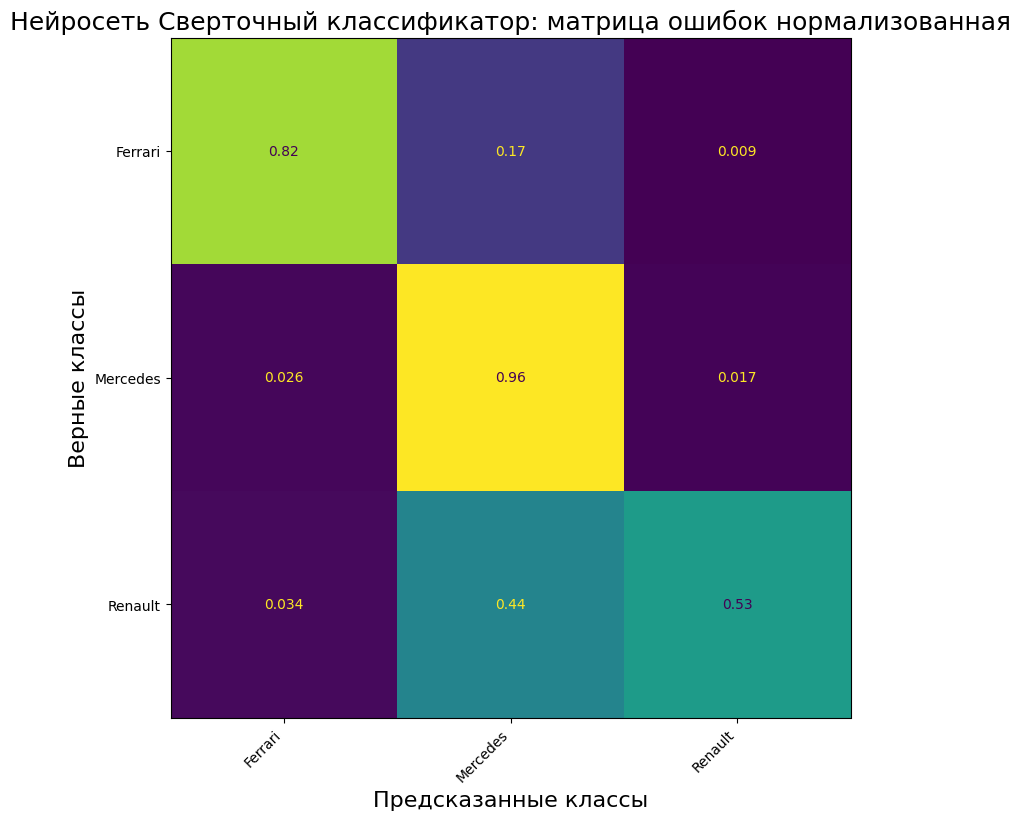

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: Ferrari               82% сеть отнесла к классу Ferrari              - ВЕРНО :-)
Класс: Mercedes              96% сеть отнесла к классу Mercedes             - ВЕРНО :-)
Класс: Renault               53% сеть отнесла к классу Renault              - ВЕРНО :-)

Средняя точность распознавания:  77%


In [29]:
# Создание последовательной модели
model_conv = Sequential()

# Первый сверточный слой
model_conv.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

# Второй сверточный слой
model_conv.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

# Третий сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.3))

# Четвертый сверточный слой
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.3))

# Слой преобразования многомерных данных в одномерные
model_conv.add(Flatten())

# Промежуточный полносвязный слой
model_conv.add(Dense(512, activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.4))

# Выходной полносвязный слой
model_conv.add(Dense(CLASS_COUNT, activation='softmax'))

# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

model_conv.save('model_avto.h5')

In [ ]:
model_conv.save('model_avto.h5')

In [30]:
from tensorflow.keras.models import load_model
model = load_model('model_avto.h5')

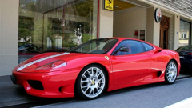

In [32]:
# Просмотр тестового изображения

from PIL import Image

# Путь к файлу изображения
test_path = '/content/cars_test/Ferrari/car_Ferrari__1006.png'
img = Image.open(test_path)

# Вывод изображения на экран
display(img)

In [33]:
img_width = 128
img_height = 64
classes = ['Ferrari', 'Mercedes', 'Renault']

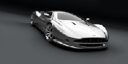

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Результат распознавания:
Ferrari 0.8713419
Mercedes 0.12761582
Renault 0.0010422835

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Изображен(а):  Ferrari


In [35]:
# Подготовка изображения для подачи в модель НС
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

# Загрузка модели
model = load_model('model_avto.h5')

# Путь к файлу изображения
test_path = '/content/cars_test/Ferrari/car_Ferrari__1011.png'
img_width = 128
img_height = 64
classes = ['Ferrari', 'Mercedes', 'Renault']

# Открытие картинки и изменение ее размера для соответсвия входу модели
img = Image.open(test_path).resize((img_width, img_height))

# Проверка результата
display(img)

# Преобразование картинки в numpy-массив чисел с плавающей запятой и нормализация значений пикселей
image = np.array(img, dtype='float64') / 255.

# добавление оси для совпадения формы входа модели; получается батч из одного примера
image = np.expand_dims(image, axis=0)

# Распознавание изображения нейросетью

pred = model.predict(image)
print('Результат распознавания:')

for i, cl in enumerate(classes):
    # Вывод предсказания сети для каждого класса
    print(cl, pred[0, i])
print()

# Вычисление индекса класса с максимальным значением вероятности и вывод имени класса
cls_image = np.argmax(model.predict(image))
print('Изображен(а): ', classes[cls_image])

In [38]:
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

def predict(img_path='./content/cars_test/Mercedes/car__107.png', model_path='./model_avto.h5'):
    classes = {0: 'Ferrari',
               1: 'Mercedes',
               2: 'Renault',
               }

    model_conv = load_model(model_path)

    img_width, img_height = 64, 128

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float64') / 255

    image = np.expand_dims(image, axis=0)
    cls_image = np.argmax(model_conv.predict(image))

    print(classes[cls_image])

In [39]:
predict(img_path='/content/cars_test/Renault/car__1043.png', model_path='model_avto.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
Renault


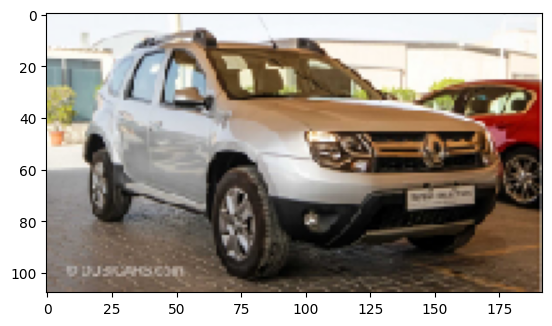

In [40]:
plt.imshow(Image.open('/content/cars_test/Renault/car__1043.png'))
plt.show()

In [41]:
# Сохранение кода скрипта в переменной text_code

text_code = '''
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model

def predict(img_path='./content/cars_test/Mercedes/car__107.png', model_path='./model_avto.h5'):
    classes = {0: 'Ferrari',
               1: 'Mercedes',
               2: 'Renault',
               }

    model_conv = load_model(model_path)

    img_width, img_height = 64, 128

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float64') / 255

    image = np.expand_dims(image, axis=0)
    cls_image = np.argmax(model_conv.predict(image))

    print(classes[cls_image])
'''

# Запись содержимого переменной в файл скрипта

with open('script.py', 'w') as f:  # Создание / открытие файла
    f.write(text_code)             # Запись в файл значения переменной text_code

In [42]:
import os
from shutil import copyfile

# Путь к директории с тестовыми изображениями
source_dir = '/content/cars_test'

# Получаем и сортируем список подпапок (ferrari, mercedes, renault)
subfolders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])

# Функция для извлечения числа из имени файла
def get_number(filename):
    return int(filename.split('__')[1].split('.')[0])

# Инициализируем счетчик для именования файлов
counter = 1

# Проходим по каждой подпапке
for subfolder in subfolders:
    subfolder_path = os.path.join(source_dir, subfolder)
    # Получаем список файлов .png в подпапке
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.png')]
    # Сортируем файлы по числу в имени
    image_files_sorted = sorted(image_files, key=get_number)
    # Выбираем первые 3 изображения
    selected_images = image_files_sorted[:3]
    # Копируем каждое выбранное изображение
    for image in selected_images:
        target_filename = f'{counter}.png'
        target_path = os.path.join('/content', target_filename)
        source_path = os.path.join(subfolder_path, image)
        copyfile(source_path, target_path)
        print(f'Скопировано {source_path} в {target_path}')
        counter += 1

Скопировано /content/cars_test/Ferrari/car_Ferrari__0.png в /content/1.png
Скопировано /content/cars_test/Ferrari/car_Ferrari__2.png в /content/2.png
Скопировано /content/cars_test/Ferrari/car_Ferrari__9.png в /content/3.png
Скопировано /content/cars_test/Mercedes/car__31.png в /content/4.png
Скопировано /content/cars_test/Mercedes/car__50.png в /content/5.png
Скопировано /content/cars_test/Mercedes/car__62.png в /content/6.png
Скопировано /content/cars_test/Renault/car__11.png в /content/7.png
Скопировано /content/cars_test/Renault/car__31.png в /content/8.png
Скопировано /content/cars_test/Renault/car__37.png в /content/9.png


In [43]:
label_txt = '''

Ferrari
Mercedes
Renault

'''

with open('label.txt', 'w') as f:  # Создание / открытие файла
    f.write(label_txt.strip())     # Запись в файл значения переменной

In [45]:
import os
from zipfile import ZipFile as Zip             # Модуль для работы с zip-архивами

# Список всех файлов
integrate_files = ['model_avto.h5', 'script.py', 'label.txt', *[f'{i}.png' for i in range(1, 10)]]

zipArchive = Zip('/content/archive.zip', 'w')  # Открытие файла, если такого не существует - будет создан новый

for file in integrate_files:                   # Для всех всем нужных файлов:
    if os.path.exists(file):                   # Если файл существует,
        zipArchive.write(file)                 # то добавление его в архив
    else:
        print(f'Файл {file} отсутствует!')     # иначе вывод на экран названия отсутствующего файла

zipArchive.close()                             # В финале архив следует закрыть, как и обычный файл

In [46]:
from google.colab import files               # Функция для скачивания данных на локальный компьютер

files.download(filename='archive.zip')       # Скачивание готового архива

print('Архив загружен')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Архив загружен
